In [2]:
#python libraries
import os, re, sys, copy, importlib

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import FFCoSTA

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DATA CLEANING

In [3]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [4]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [5]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [6]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [7]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

outdoor_temp_columns = data.columns.str.endswith('OutdoorEntrance_temperature')
indoor_temp_columns = data.columns.str.endswith('temperature') & np.logical_not(outdoor_temp_columns)
door_columns = data.columns.str.endswith('door')
timing_columns = data.columns.str.startswith('sin_') | data.columns.str.startswith('cos_')

In [8]:
import HAMDataset
importlib.reload(HAMDataset)
warmup_length = 96
label_length = 8
train_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns)
train_data.add_data(train_df_1)
train_data.add_data(train_df_2)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=False)

val_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns)
val_data.add_data(val_df)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

test_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns)
test_data.add_data(test_df)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [9]:
warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels = next(iter(train_loader))

### DEFINE PBM MODEL

In [10]:
import asset
import PBM
import importlib
importlib.reload(PBM)
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)

thermoPBM = PBM.thermoPBM(house)


In [27]:
pbm_out = torch.zeros((test_df.shape[0]-96-8-1,  13))
pbm_out_wall = torch.zeros((test_df.shape[0]-96-8-1, 13))
true = torch.zeros((test_df.shape[0]-96-8-1, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels) in enumerate(test_loader):
    if i == 0:
        T_room = FFCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = torch.zeros_like(T_room)
    
    for _ in range(N):
        T_room, T_wall = thermoPBM(T_room, T_wall, outdoor_temp[0, 0], delta_t)
    
    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall

    true[i] = FFCoSTA.pbm_temp_from_sensor(indoor_temp)


MAE: 1.4052467346191406


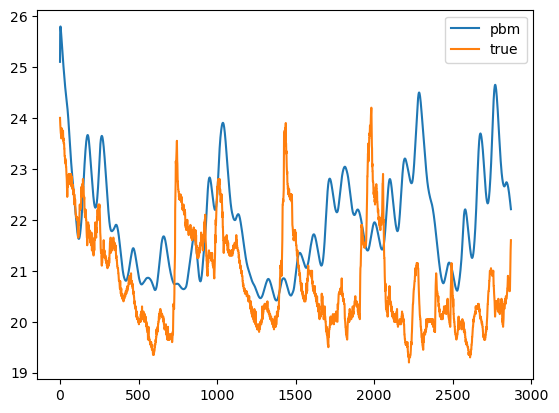

In [28]:
plt.plot(pbm_out.detach()[:, 0], label="pbm")
# plt.plot(pbm_out_wall.detach()[:, 0], label="pbm wall")
plt.plot(true[:, 0], label="true")
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true[:, 0] - pbm_out[:, 0]))}')

### CoSTA

In [13]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [14]:
import FFNNModel
importlib.reload(FFNNModel)
importlib.reload(PBM)

house = asset.Asset(zones, connections)
thermoPBM = PBM.thermoPBM(house)

In [15]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.01
l2_reg = 0.001

model.train(train_loader, val_loader, epochs, lr, l2_reg)

KeyboardInterrupt: 

In [ ]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model_1 = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.001
l2_reg = 0.001

model_1.train(train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Epoch Train MAE: 0.367891788482666
Epoch: 1, Val MAE: 0.31902262568473816
Epoch: 2, Epoch Train MAE: 0.3608448803424835
Epoch: 2, Val MAE: 0.313214510679245
Epoch: 3, Epoch Train MAE: 0.362377405166626
Epoch: 3, Val MAE: 0.28536513447761536
Epoch: 4, Epoch Train MAE: 0.35262754559516907
Epoch: 4, Val MAE: 0.2866768538951874
Epoch: 5, Epoch Train MAE: 0.3493293523788452
Epoch: 5, Val MAE: 0.28290677070617676
Epoch: 6, Epoch Train MAE: 0.3460879325866699
Epoch: 6, Val MAE: 0.2810557186603546
Epoch: 7, Epoch Train MAE: 0.34399327635765076
Epoch: 7, Val MAE: 0.27811798453330994
Epoch: 8, Epoch Train MAE: 0.3409901261329651
Epoch: 8, Val MAE: 0.27595439553260803
Epoch: 9, Epoch Train MAE: 0.33781105279922485
Epoch: 9, Val MAE: 0.2742752730846405
Epoch: 10, Epoch Train MAE: 0.3368159830570221
Epoch: 10, Val MAE: 0.2739602327346802
Epoch: 11, Epoch Train MAE: 0.33656859397888184
Epoch: 11, Val MAE: 0.272304505109787
Epoch: 12, Epoch Train MAE: 0.3345301151275635
Epoch: 12, Val MAE: 

In [ ]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model_2 = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.0001
l2_reg = 0.001

model_2.train(train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Epoch Train MAE: 0.39347901940345764
Epoch: 1, Val MAE: 0.27144744992256165
Epoch: 2, Epoch Train MAE: 0.3752105236053467
Epoch: 2, Val MAE: 0.26996466517448425
Epoch: 3, Epoch Train MAE: 0.3670215308666229
Epoch: 3, Val MAE: 0.2714771330356598
Epoch: 4, Epoch Train MAE: 0.36114680767059326
Epoch: 4, Val MAE: 0.27396416664123535
Epoch: 5, Epoch Train MAE: 0.3560517132282257
Epoch: 5, Val MAE: 0.2775603234767914
Epoch: 6, Epoch Train MAE: 0.3517477214336395
Epoch: 6, Val MAE: 0.2809154987335205
Epoch: 7, Epoch Train MAE: 0.34823083877563477
Epoch: 7, Val MAE: 0.28363025188446045
Epoch: 8, Epoch Train MAE: 0.3455115258693695
Epoch: 8, Val MAE: 0.285485178232193
Epoch: 9, Epoch Train MAE: 0.3434590697288513
Epoch: 9, Val MAE: 0.2863355875015259
Epoch: 10, Epoch Train MAE: 0.34187430143356323
Epoch: 10, Val MAE: 0.28648683428764343
Epoch: 11, Epoch Train MAE: 0.34053948521614075
Epoch: 11, Val MAE: 0.2862124443054199
Epoch: 12, Epoch Train MAE: 0.33932363986968994
Epoch: 12, Val 

In [ ]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model_3 = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.001
l2_reg = 0.01

model_3.train(train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Epoch Train MAE: 0.3760449290275574
Epoch: 1, Val MAE: 0.2924691140651703
Epoch: 2, Epoch Train MAE: 0.3653860092163086
Epoch: 2, Val MAE: 0.2879082262516022
Epoch: 3, Epoch Train MAE: 0.3583263158798218
Epoch: 3, Val MAE: 0.2863783538341522
Epoch: 4, Epoch Train MAE: 0.35419726371765137
Epoch: 4, Val MAE: 0.2866372764110565
Epoch: 5, Epoch Train MAE: 0.35364580154418945
Epoch: 5, Val MAE: 0.2849331200122833
Epoch: 6, Epoch Train MAE: 0.3521127700805664
Epoch: 6, Val MAE: 0.2848125994205475
Epoch: 7, Epoch Train MAE: 0.35139966011047363
Epoch: 7, Val MAE: 0.28476524353027344
Epoch: 8, Epoch Train MAE: 0.3514377474784851
Epoch: 8, Val MAE: 0.2835273742675781
Epoch: 9, Epoch Train MAE: 0.3505251109600067
Epoch: 9, Val MAE: 0.28455081582069397
Epoch: 10, Epoch Train MAE: 0.35041242837905884
Epoch: 10, Val MAE: 0.28389689326286316
Epoch: 11, Epoch Train MAE: 0.3498999774456024
Epoch: 11, Val MAE: 0.28410911560058594
Epoch: 12, Epoch Train MAE: 0.3497074842453003
Epoch: 12, Val MA

In [ ]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model_4 = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.001
l2_reg = 0.0001

model_4.train(train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Epoch Train MAE: 0.3664992153644562
Epoch: 1, Val MAE: 0.3262324333190918
Epoch: 2, Epoch Train MAE: 0.3635551929473877
Epoch: 2, Val MAE: 0.29234176874160767
Epoch: 3, Epoch Train MAE: 0.35572052001953125
Epoch: 3, Val MAE: 0.28593018651008606
Epoch: 4, Epoch Train MAE: 0.3481329679489136
Epoch: 4, Val MAE: 0.2818131744861603
Epoch: 5, Epoch Train MAE: 0.3438970446586609
Epoch: 5, Val MAE: 0.27556338906288147
Epoch: 6, Epoch Train MAE: 0.3408065438270569
Epoch: 6, Val MAE: 0.272102952003479
Epoch: 7, Epoch Train MAE: 0.336688369512558
Epoch: 7, Val MAE: 0.27059558033943176
Epoch: 8, Epoch Train MAE: 0.3355741500854492
Epoch: 8, Val MAE: 0.26833149790763855
Epoch: 9, Epoch Train MAE: 0.332145631313324
Epoch: 9, Val MAE: 0.26811859011650085
Epoch: 10, Epoch Train MAE: 0.3309662342071533
Epoch: 10, Val MAE: 0.27134761214256287
Epoch: 11, Epoch Train MAE: 0.330849826335907
Epoch: 11, Val MAE: 0.27137771248817444
Epoch: 12, Epoch Train MAE: 0.3292281925678253
Epoch: 12, Val MAE: 

In [ ]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'models/CoSTA.pt')

In [16]:
FFCoSTA_model = FFCoSTA.FFCoSTA(thermoPBM, NNModel)
FFCoSTA_model.load_state_dict(torch.load('models/FFCoSTA.pt'))

<All keys matched successfully>

In [21]:
sim_n = len(test_data)

pbm_out = torch.zeros((sim_n, 13))
pbm_out_wall = torch.zeros((sim_n, 13))
true = torch.zeros((sim_n, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels) in enumerate(list(test_loader)[:sim_n]):
    
    if i % 96 == 0:
        T_room_warmup = FFCoSTA.pbm_temp_from_sensor(warmup_indoor[:, 0, :])
        T_wall_warmup = torch.zeros_like(T_room_warmup)
        
        for n in range(warmup_indoor.shape[1]):
            for _ in range(N):
                T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n, :], delta_t)


        T_room = FFCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = T_wall_warmup
    
    # elif i % 96 == 0:
    #     T_room = FFCoSTA.pbm_temp_from_sensor(indoor_temp)

    T_room, T_wall = FFCoSTA_model(T_room, T_wall, outdoor_temp, door, timing, N, delta_t, 1)

    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall
    true[i] = FFCoSTA.pbm_temp_from_sensor(labels[0, 0].unsqueeze(0))


MAE: 0.942330002784729


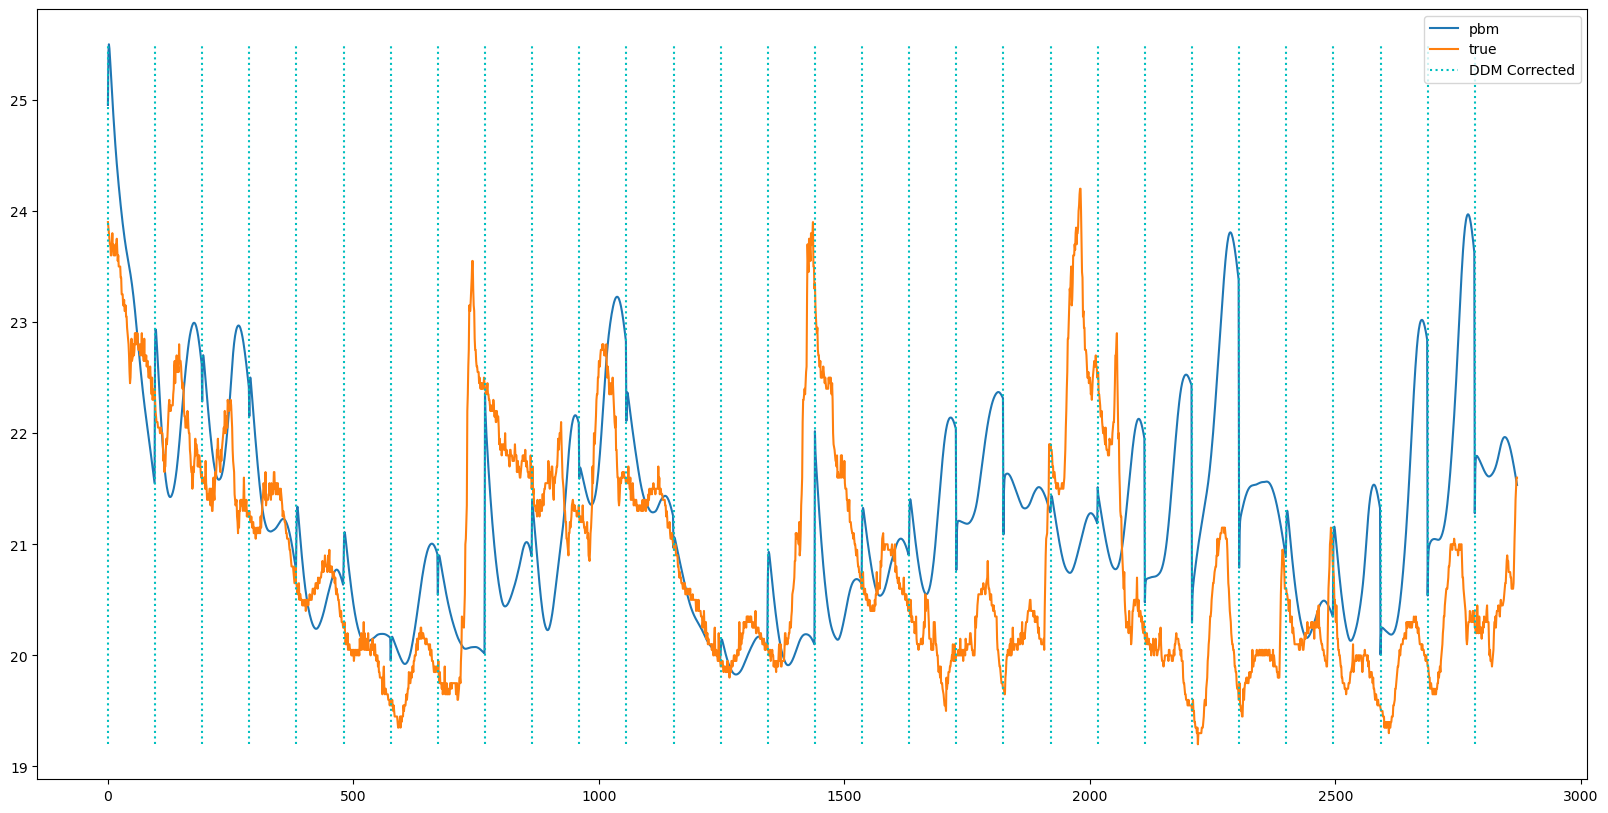

In [24]:
room = 0
plt.figure(figsize=(20, 10))
plt.plot(pbm_out.detach()[:sim_n, room], label="pbm")
# plt.plot(pbm_out_wall.detach()[:sim_n, room], label="pbm wall")
plt.plot(true[:sim_n, room], label="true")
plt.vlines(x = range(0, len(true), 96), ymax=np.max(np.maximum.reduce([true[:, 0].detach().numpy(), pbm_out[:, 0].detach().numpy()])), ymin=np.min(np.minimum.reduce([true[:, 0].detach().numpy(), pbm_out[:, 0].detach().numpy()])), linestyles='dotted', colors='c', label='DDM Corrected')
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true[:sim_n, 0] - (pbm_out[:sim_n, 0])))}')